In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [28]:
df = pd.read_csv("./Root_Insurance_data.csv")

In this notebook we implement gradient descent to minimize cost per customer acquired, 
$$
    \underset {b_i \geq 0} {\arg\,\min\,} \mathcal L(b_1,\ldots,b_{36}) = \frac {\mathbb E[ \mathrm{Cost} ]}{\mathbb E[\# \mathrm{policies}]}
$$
with the constraint that the solution acuire at least 400 customers per 10,000.

If we naively minimize cost per customer acquired without any constraint, all the bids will tend to zero. Indeed, if we bid \\$0 on every customer, we'll still hold the 5th (last) ranking for every customer, where we would expect to maintain about 2\% click-thru rate on average. Of the customers that click, some, about 40\% on average, will end up buying policies and we will have achieved the absolute minimal cost per customer acquired, ending up with about 80 customers per 10,000.

To ensure we find a solution which acquires enough customers, we multiply the cost per customer acquired by a barrier function:
$$
    \underset {b_i \geq 0} {\arg\,\min\,} \mathcal L(b_1,\ldots,b_{36}) = \frac {\mathbb E[ \mathrm{Cost} ]}{\mathbb E[\# \mathrm{policies}]} \bigg( \frac 1 {\mathbb E[ \mathrm{Policies} ] - 400} + 1 \bigg).
$$

This forces the loss function to infinity as the number of expected policies tends to 400, and, since the barrier function tends to one for points far enough away from the barrier, it is comparable to the cost per customer which we wish to estimate.

Thus, by optimizing the loss function multiplied by a barrier, we will find an efficient solution within the constrained region.

Finally, we optimize the loss function by running gradient flow on its logarithm, which is equivalent to minimizing the objective function itself.

# Use Logistic Regression to get the Probabilities of Different Customers to Buy Policies

We're estimating the probabilities using only customers who click, so that this estimates the true probability of customers to buy a policy, independent of where our ad was ranked.

As we observed in the modeling phase, the variables for unknown insurance status and marital status are not statistically significant, so we will fit the model omiting these variables.

In [29]:
# create data frame of customers who clicked our ad
# we will estimate the probabilities for each customer to buy a policy conditioned on clicking the ad

xdf_click = pd.get_dummies(df["Currently Insured"].loc[df.click])[["Y","unknown"]]
# rename the column without a space
xdf_click.columns = ["insured","unknown"]
xdf_click[["cars2","cars3"]] = pd.get_dummies(df["Number of Vehicles"].loc[df.click])[[2,3]]
xdf_click[["drivers2"]] = pd.get_dummies(df["Number of Drivers"].loc[df.click])[[1]]
xdf_click[["married"]] = pd.get_dummies(df["Marital Status"].loc[df.click])[["M"]]
xdf_click[["policies_sold"]] = df[["policies_sold"]].loc[df.click].copy()

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
glm = LogisticRegression()

X = xdf_click[["insured","cars2","cars3","drivers2"]].to_numpy()
y = xdf_click["policies_sold"].to_numpy()
glm.fit(X,y)

LogisticRegression()

In [32]:
# number of categories
cat = 36
# initialize np array for class probabilities
p = np.zeros(cat)
# create list to remember the numbers
ls = pd.DataFrame(columns=["insured","cars","drivers","married"])
idx = 0
for i in ["Y","unknown","N"]:
    for c in [1,2,3]:
        for d in [1,2]:
            for m in ["M","S"]:
                x = [[ (i=="Y"),(c==2),(c==3),(d==2)]]
                # get probability for class idx
                p[idx] = glm.predict_proba(x)[0,1]
                ls = ls.append({"insured":i,"cars":c,"drivers":d,"married":m},ignore_index=True)
                idx+=1

# Get Coefficients for Click-Thru rate by Rank

In [33]:
click_rates_by_rank = df.groupby("rank").click.mean().to_numpy()

# Gradient Descent for Hybrid Model

Here, $\lambda = 10 \frac {(\overline r-1)}{5 - \overline r}$.

In [38]:
lm = np.zeros(36)
df["class"]=0
idx=0
r=0
for i in ["Y","unknown","N"]:
    for c in [1,2,3]:
        for d in [1,2]:
            for m in ["M","S"]:
                # get the average rank for class idx
                r = df["rank"].loc[(df["Marital Status"]==m)&(df["Number of Drivers"]==d)\
                                 &(df["Number of Vehicles"]==c)&(df["Currently Insured"]==i)].mean()
                df.loc[(df["Marital Status"]==m)&(df["Number of Drivers"]==d)\
                                 &(df["Number of Vehicles"]==c)&(df["Currently Insured"]==i),"class"] = idx
                # there is one class (unknown insurance, single, 3 vehicles, 2 drivers); idx = 24
                # that has zero representatives, 
                # for this one we will use the global average bid
                # alternatively we could estimate it with logistic regression
                # for now we set it to the average rank=3.1841
                if np.isnan(r):
                    r = df["rank"].mean()
                lm[idx] = 10*(r - 1)/(5-r)
                idx+=1

In [17]:
# regularization parameter
alpha = .65

In [16]:

# find the expected click rate for each bid
# if change the CDF also update dRdb in dLdb(bids,batch)
def ExpectedClickRate(bids):
    arr = np.zeros(36)
    for i in range(36):
        s = 0 
        if bids[i]>10:
            for j in range(5):
                prob = (10/(10+lm[i]))*np.exp(-(bids[i]-10)/lm[i])
                s += scipy.special.binom(4,j)*click_rates_by_rank[j]*(prob**j)*((1-prob)**(4-j))
        else:
            for j in range(5):
                prob = 1 - (bids[i]/10)*lm[i]/(10+lm[i])
                s += scipy.special.binom(4,j)*click_rates_by_rank[j]*(prob**j)*((1-prob)**(4-j))
        arr[i]=s
    return arr

def ExpectedCost(bids,batch):
    clicks = ExpectedClickRate(bids)
    s = 0
    for a in batch:
        # add up bid for each customer times probability to click
        s+= bids[a]*clicks[a]
    return s

        
def ExpectedPoliciesSold(bids,batch):
    clicks = ExpectedClickRate(bids)
    s = 0
    for a in batch:
        # add up probability to click times probability to buy conditioned on click
        s+= p[a]*clicks[a]
    return s
    
# Loss here is log(cost per customer acquired) with constraint to ensure minimum is greater than 400. 
# Seek to minimize loss function
def Loss(bids,batch):
    policies = ExpectedPoliciesSold(bids,batch)
    return np.log( ExpectedCost(bids,batch)) - np.log(policies) + alpha*np.log((policies-399)/(policies-400))

# calculate the gradient of Loss function
# to change CDF need to chance dRdb
def dLdb(bids,batch):
    clicks = ExpectedClickRate(bids)
    cost = ExpectedCost(bids,batch)
    policies = ExpectedPoliciesSold(bids,batch)
    
    # compute gradient of ExpectedClickRate
    dRdb = np.zeros(36)
    # compute gradient of ExpectedCost
    dCdb = np.zeros(36)
    # compute gradient of ExpectedPoliciesSold
    dPdb = np.zeros(36)
    for i in range(36):
        s=0
        if bids[i]>10:
            prob = (10/(10+lm[i]))*np.exp(-(bids[i]-10)/lm[i])
            dpdb = -(10/(10+lm[i]))*np.exp(-(bids[i]-10)/lm[i])/lm[i]
        else:
            prob = 1 - lm[i]*(bids[i]/10)/(10+lm[i])
            dpdb = -(lm[i]/10)/(10+lm[i])
        for j in range(5):
            s += scipy.special.binom(4,j)*click_rates_by_rank[j]*j*(prob**(j-1))*((1-prob)**(4-j))*dpdb
            s -= scipy.special.binom(4,j)*click_rates_by_rank[j]*(prob**j)*((1-prob)**(3-j))*(4-j)*dpdb
        
        # set value of gradient Expected click rate
        dRdb[i] = s
        
        dCdb[i] += clicks[i]
        dCdb[i] += bids[i]*dRdb[i]
        
        dPdb[i] += p[i]*dRdb[i]
        
    # now compute the gradient of Loss
    arr = np.zeros(36)
    for a in batch:
        arr[a] += dCdb[a]/cost - dPdb[a]/policies + alpha*dPdb[a]*( 1/(policies - 399) - 1/(policies-400))
    return arr

Number of Iterations Performed: 29669
Final bids =  [ 4.83675569  4.51914476  5.3784541   5.41659753  3.56590062  3.60177059
  4.58636127  4.59731314  3.34201539  3.33424812  4.33382715  4.3134977
  6.44756991  6.59616941  7.03910891  6.989196    5.69546412  5.65828293
  6.06794371  6.14040513  4.92498097  5.07040853  5.87557452 10.
  7.67089213  7.51739714  7.61212137  7.58314208  6.20033719  6.13577726
  6.84183362  6.9756924   5.80164398  5.7736762   7.1214125   7.11152196]
Cost  6453.04413896888
Policies  416.6756919014682
Cost per policy  15.486970477017506


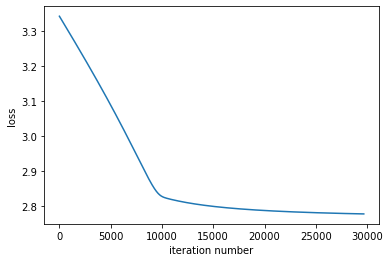

In [20]:
# Initialize all bids at $10
b=10*np.ones(36)

# Number of iterations to do grad descent
niterations=int(3*1e4)


# Learning rate
epsilon=.1

m=10000
# minimum possible bid
min_val = 0.01

samples = df["class"].to_numpy()
batch = samples #np.random.choice(samples, size=m, replace=True)

losses=np.zeros(niterations+1)
losses[0]=Loss(b, batch)
for i in range(niterations):
    # batch = np.random.choice(samples, size=m, replace=True)
    grad = dLdb(b, batch)
    if sum(np.abs(grad))<.01:
        print("Number of Iterations Performed:",i)
        break
    b = b-epsilon*grad
    # set any negative values to min_val
    b[b<min_val] = min_val
    losses[i+1]=Loss(b,batch)
    if ExpectedPoliciesSold(b,batch)<400:
        break

plt.figure()
plt.plot(losses[losses>0])
plt.ylabel("loss")
plt.xlabel("iteration number")
#plt.yscale("log")
print("Final bids = ",b)
print("Cost ", ExpectedCost(b,samples))
print("Policies ", ExpectedPoliciesSold(b,samples))
print("Cost per policy ", ExpectedCost(b,samples)/ExpectedPoliciesSold(b,samples))

# Variance Estimate of the Solution


Now that we have optimized the cost per policy sold subject to the constraint that we sell at least 400 policies per 10,000, on average, we want to estimate a confidence percentage that our bid strategy will actually acquire at least 400 customers out of 10,000. 

To do this we use bootstrapping to repeatedly produce samples of 10,000 customers from the emperical distribution and use this to estimate the standard deviation of policies per 10,000


In [21]:
niterations=10000
arr= np.zeros(niterations)
for i in range(niterations):
    batch = np.random.choice(samples, size=10000, replace=True)
    arr[i] = ExpectedPoliciesSold(b, batch)
m = np.mean(arr)
s = np.std(arr)
print("Mean: ", m)
print("St Dev: ",s)

Mean:  416.6822107189277
St Dev:  2.277501185107887


We conclude with high degree of confidence that the true number of customers will be greater than 400.

In [22]:
from scipy.stats import norm

norm.cdf(400, loc=m,scale=s)

1.1963936642218857e-13

In [25]:
# There is one customer class that has no representatives. We set this bid value to NaN
b[b==10] = np.NaN
ls["bid"] = b
ls["p"] = p

In [26]:
ls.sort_values("bid",ascending=False)

,insured,cars,drivers,married,bid,p
24,N,1,1,M,7.670892,0.467218
26,N,1,2,M,7.612121,0.531141
27,N,1,2,S,7.583142,0.531141
25,N,1,1,S,7.517397,0.467218
34,N,3,2,M,7.121412,0.415588
35,N,3,2,S,7.111522,0.415588
14,unknown,1,2,M,7.039109,0.531141
15,unknown,1,2,S,6.989196,0.531141
31,N,2,2,S,6.975692,0.432213
30,N,2,2,M,6.841834,0.432213
